Celda 0 — Bootstrap / paths:

In [1]:
# Celda 0 — Rutas base y utilidades simples

from pathlib import Path
import sys, os, re, json, math, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Raíz del repo
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

OUT = ROOT / "outputs"
SUMMARY = OUT / "summary"
SUMMARY.mkdir(parents=True, exist_ok=True)

print("ROOT   :", ROOT)
print("OUT    :", OUT)
print("SUMMARY:", SUMMARY)

# Helpers de path / tiempo
def _abs_run_dir(run_dir: str | Path) -> Path:
    p = Path(run_dir)
    return p if p.is_absolute() else (OUT / p)

def run_mtime(run_dir: str | Path) -> float:
    """Máx mtime de carpeta y su primer nivel (robusto)."""
    p = _abs_run_dir(run_dir)
    try:
        mt = [p.stat().st_mtime]
        for c in p.iterdir():
            try:
                mt.append(c.stat().st_mtime)
            except Exception:
                pass
        return max(mt)
    except Exception:
        return 0.0

def canonical_method(s: str) -> str:
    """Normaliza etiquetas de método (coincide con tu lógica previa)."""
    if not isinstance(s, str):
        return "unknown"
    t = s.lower()
    if ("rehearsal" in t) and ("+ewc" in t or "_ewc" in t):
        return "rehearsal+ewc"
    if "sca-snn" in t: return "sca-snn"
    if re.search(r"\bsa[-_]snn\b", t): return "sa-snn"
    if re.search(r"\bas[-_]snn\b", t): return "as-snn"
    if "colanet" in t: return "colanet"
    if re.search(r"\bewc\b", t) or "ewc_lam" in t: return "ewc"
    if "rehearsal" in t: return "rehearsal"
    if "naive" in t or "finetune" in t or "fine-tune" in t: return "naive"
    return t.split("_")[0]

ROOT   : /home/cesar/proyectos/TFM_SNN
OUT    : /home/cesar/proyectos/TFM_SNN/outputs
SUMMARY: /home/cesar/proyectos/TFM_SNN/outputs/summary


Celda 1 — Config de selección

In [2]:
# Celda 1 — Config de selección y salida

# Etiqueta de este corte (todo lo generado irá aquí)
SUMMARY_LABEL = "paper_set_accurate_2025-11-03"
THIS_SUMMARY = SUMMARY / SUMMARY_LABEL
THIS_SUMMARY.mkdir(parents=True, exist_ok=True)

# Filtros duros (ajusta a tu foto “buena”)
PRESET_FILTER   = "accurate"        # None para no filtrar
ENCODER_FILTER  = "rate"            # None para no filtrar
SEED_FILTER     = 42                # None para no filtrar
METHODS_KEEP    = {"sa-snn","as-snn","sca-snn","ewc","rehearsal","naive"}  # set() para no filtrar

# Comparabilidad (mismo modelo/T/amp) y batch_size “tolerante”
MODEL_MATCH_SUBSTR = "PilotNetSNN_66x200_gray"  # substring
T_TARGET           = 30
AMP_REQUIRED       = True
BATCH_SIZE_TARGET  = 160        # se usa de forma tolerante: igual o NaN (cuando no conste)
STRICT_CFG         = True       # si False, no se exige comparabilidad estricta

# Corte temporal
MTIME_FROM = dt.datetime(2025, 10, 31, 0, 0, 0)  # None para no filtrar por fecha

# Restringir a runs del runner nuevo (run_row.*)
ONLY_NEW_RUNNER = True

# Filtros opcionales extra
TAG_INCLUDE_SUBSTR = []         # p.ej., ["best_", "grid05_"]
RUN_DIR_WHITELIST  = []         # p.ej., ["continual_accurate_ewc_..."]

# Re-evaluar eval_matrix si falta, SOLO en runs ya prefiltrados
FORCE_REEVAL_EVALMATRIX = True

# Salidas “de ranking”
TOPN = 6
ALPHA_COMPOSITE = 0.5  # peso mae_norm vs forget_norm en score

Celda 2 — Construcción de la tabla base (una sola vez, fuente única)

In [3]:
# Celda 2 — Tabla base desde results_io

from src.results_io import build_results_table

# 1) Construye/recarga la tabla completa de OUT
tbl_path = SUMMARY / "results_table.csv"
def _needs_rebuild():
    if not tbl_path.exists():
        return True
    csv_mtime = tbl_path.stat().st_mtime
    runs = [p for p in OUT.glob("continual_*") if p.is_dir()]
    return any(p.stat().st_mtime > csv_mtime for p in runs)

if _needs_rebuild():
    df_all = build_results_table(OUT)
    # Marca runner nuevo
    def _is_new_runner(rd: str) -> bool:
        p = _abs_run_dir(rd)
        return (p / "run_row.json").exists() or (p / "run_row.csv").exists()
    df_all["is_new_runner"] = df_all["run_dir"].apply(_is_new_runner)
    df_all.to_csv(tbl_path, index=False)
    print("[OK] Tabla reconstruida:", tbl_path, "| filas:", len(df_all))
else:
    df_all = pd.read_csv(tbl_path)
    if "is_new_runner" not in df_all.columns:
        def _is_new_runner(rd: str) -> bool:
            p = _abs_run_dir(rd)
            return (p / "run_row.json").exists() or (p / "run_row.csv").exists()
        df_all["is_new_runner"] = df_all["run_dir"].apply(_is_new_runner)
    print("[INFO] Tabla cargada:", tbl_path, "| filas:", len(df_all))

# 2) Añade mtime y método base
df_all["mtime"] = df_all["run_dir"].apply(run_mtime)
df_all["mtime_dt"] = pd.to_datetime(df_all["mtime"], unit="s")
df_all["method_base"] = df_all["method"].astype(str).apply(canonical_method)

display(df_all.head(3))

[OK] Tabla reconstruida: /home/cesar/proyectos/TFM_SNN/outputs/summary/results_table.csv | filas: 101


,run_dir,preset,method,encoder,model,seed,T,B,batch_size,amp,...,circuito1_forget_abs,circuito1_forget_rel,circuito2_best_mae,circuito2_final_mae,circuito2_forget_abs,circuito2_forget_rel,is_new_runner,mtime,mtime_dt,method_base
0,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,accurate,as-snn_gr_0.3_lam_1.59168,rate,PilotNetSNN_66x200_gray,42,30.0,32.0,32.0,True,...,0.033481,0.268158,0.134521,0.134521,0.0,0.0,False,1.760794e+09,2025-10-18 13:32:20.574938297,as-snn
1,continual_accurate_as-snn_gr_0.3_lam_1.59168_a...,accurate,as-snn_gr_0.3_lam_1.59168_att_f6_scale_on,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.000000,0.000000,0.222565,0.222565,0.0,0.0,True,1.762061e+09,2025-11-02 05:15:19.474066496,as-snn
2,continual_accurate_as-snn_gr_0.3_lam_1.6_grid0...,accurate,as-snn_gr_0.3_lam_1.6,rate,PilotNetSNN_66x200_gray,42,30.0,32.0,32.0,True,...,0.032064,0.224605,0.155070,0.155070,0.0,0.0,True,1.761734e+09,2025-10-29 10:29:16.076847553,as-snn


Celda 3 — (Opcional) re-evaluar eval_matrix donde falte, solo sobre pre-selección:

In [4]:
# Celda 3 — Re-evalúo eval_matrix SOLO en la preselección

from src.results_io import ensure_eval_matrix_files

def _preselect(df):
    dd = df.copy()
    if PRESET_FILTER:
        dd = dd[dd["preset"] == PRESET_FILTER]
    if ENCODER_FILTER:
        dd = dd[dd["encoder"] == ENCODER_FILTER]
    if SEED_FILTER is not None:
        dd = dd[dd["seed"] == SEED_FILTER]
    if METHODS_KEEP:
        dd = dd[dd["method_base"].isin(METHODS_KEEP)]
    if ONLY_NEW_RUNNER and "is_new_runner" in dd.columns:
        dd = dd[dd["is_new_runner"] == True]
    if MTIME_FROM is not None:
        dd = dd[dd["mtime"] >= MTIME_FROM.timestamp()]
    if TAG_INCLUDE_SUBSTR:
        mask = dd["run_dir"].astype(str).apply(lambda s: any(t in s for t in TAG_INCLUDE_SUBSTR))
        dd = dd[mask]
    if RUN_DIR_WHITELIST:
        dd = dd[dd["run_dir"].isin(RUN_DIR_WHITELIST)]
    return dd

df_pre = _preselect(df_all)
print(f"[INFO] Preselección para reevaluación: {len(df_pre)} runs.")

if FORCE_REEVAL_EVALMATRIX and len(df_pre):
    for rd in df_pre["run_dir"]:
        try:
            ensure_eval_matrix_files(_abs_run_dir(rd))
            print("[OK] reeval:", rd)
        except Exception as e:
            print("[WARN] reeval fallida:", rd, "|", type(e).__name__, ":", e)

# Recarga tabla tras posibles reevaluaciones
df_all = build_results_table(OUT)
if "is_new_runner" not in df_all.columns:
    def _is_new_runner(rd: str) -> bool:
        p = _abs_run_dir(rd)
        return (p / "run_row.json").exists() or (p / "run_row.csv").exists()
    df_all["is_new_runner"] = df_all["run_dir"].apply(_is_new_runner)
df_all["mtime"] = df_all["run_dir"].apply(run_mtime)
df_all["mtime_dt"] = pd.to_datetime(df_all["mtime"], unit="s")
df_all["method_base"] = df_all["method"].astype(str).apply(canonical_method)
print("[OK] Tabla recargada tras reevaluación. Filas:", len(df_all))

[INFO] Preselección para reevaluación: 11 runs.
[OK] reeval: continual_accurate_as-snn_gr_0.3_lam_1.59168_att_f6_scale_on_best_as_gr03_lam1p59168_f6_scale_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_ewc_lam_1e+07_lam_1e+07_best_ewc_lam1e7_f200_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_ewc_lam_3e+07_lam_3e+07_best_ewc_lam1e7_f200_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_ewc_lam_7e+08_lam_7e+08_best_ewc_lam7e8_f1000_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_rehearsal_buf_3000_rr_10_best_reh_buf3000_rr10_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_sa-snn_best_sa_k8_tau28_p2m_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_sa-snn_sa_k10_tau32_p5m_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: continual_accurate_sa-snn_sa_k8_tau28_flatten_rate_model-PilotNetSNN_66x200_gray_seed_42
[OK] reeval: co

Celda 4 — Filtros finales y comparabilidad:

In [5]:
# Celda 4 — Filtro final (preset/encoder/seed/fecha/met/matcher) + comparabilidad

def _batch_size_filled(row: pd.Series) -> float:
    """Backfill de batch_size mirando run_row.json o task_1_circuito1/manifest.json."""
    bs = pd.to_numeric(row.get("batch_size"), errors="coerce")
    if pd.notna(bs):
        return float(bs)
    rd = _abs_run_dir(row["run_dir"])

    def _read_json_silent(p: Path):
        try:
            if p.exists():
                return json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            pass
        return {}

    # run_row.json
    j = _read_json_silent(rd / "run_row.json")
    cand = j.get("batch_size") if j else None
    if cand is None and j:
        cand = j.get("meta", {}).get("batch_size")
    if cand is not None:
        try:
            return float(cand)
        except Exception:
            pass

    # manifest del primer task
    man = _read_json_silent(rd / "task_1_circuito1" / "manifest.json")
    meta = man.get("meta", {}) if isinstance(man, dict) else {}
    cand = meta.get("batch_size")
    if cand is not None:
        try:
            return float(cand)
        except Exception:
            pass

    return float("nan")  # equivalente a np.nan


# 1) Filtros duros
df_sel = df_all.copy()
if PRESET_FILTER:
    df_sel = df_sel[df_sel["preset"] == PRESET_FILTER]
if ENCODER_FILTER:
    df_sel = df_sel[df_sel["encoder"] == ENCODER_FILTER]
if SEED_FILTER is not None:
    df_sel = df_sel[df_sel["seed"] == SEED_FILTER]
if METHODS_KEEP:
    df_sel = df_sel[df_sel["method_base"].isin(METHODS_KEEP)]
if ONLY_NEW_RUNNER and "is_new_runner" in df_sel.columns:
    df_sel = df_sel[df_sel["is_new_runner"] == True]
if MTIME_FROM is not None:
    df_sel = df_sel[df_sel["mtime"] >= MTIME_FROM.timestamp()]
if TAG_INCLUDE_SUBSTR:
    mask = df_sel["run_dir"].astype(str).apply(lambda s: any(t in s for t in TAG_INCLUDE_SUBSTR))
    df_sel = df_sel[mask]
if RUN_DIR_WHITELIST:
    df_sel = df_sel[df_sel["run_dir"].isin(RUN_DIR_WHITELIST)]

# 2) Comparabilidad (mismo modelo/T/amp), batch_size tolerante
if STRICT_CFG:
    model_ok = df_sel["model"].astype(str).str.contains(MODEL_MATCH_SUBSTR, na=False)
    T_ok     = (pd.to_numeric(df_sel["T"], errors="coerce") == T_TARGET)
    amp_ok   = df_sel["amp"].astype(str).str.lower().isin(["true","1","yes"]) if AMP_REQUIRED else True
    # batch size tolerante (igual a target o NaN/backfilled)
    df_tmp = df_sel.copy()
    df_tmp["batch_size_filled"] = df_tmp.apply(_batch_size_filled, axis=1)
    bs = pd.to_numeric(df_tmp["batch_size_filled"], errors="coerce")
    bs_ok = bs.eq(BATCH_SIZE_TARGET) | bs.isna()

    mask_cfg = model_ok & T_ok & (amp_ok if isinstance(amp_ok, pd.Series) else True) & bs_ok
    df_sel = df_tmp[mask_cfg].copy()

if df_sel.empty:
    raise SystemExit("[ERROR] No hay runs tras los filtros. Ajusta fecha/preset/métodos o desactiva STRICT_CFG.")

# 3) Asegura columnas métricas clave
task_cols = [c for c in df_sel.columns if c.endswith("_final_mae")]
assert task_cols, "No se encuentran columnas *_final_mae."
# última tarea (por nombre)
def _key(col):
    base = col.replace("_final_mae","")
    m = re.search(r"(\d+)$", base)
    idx = int(m.group(1)) if m else 0
    base = re.sub(r"\d+$","", base)
    return (base, idx)
task_cols_sorted = sorted(task_cols, key=_key)
MAE_COL = task_cols_sorted[-1]
MAE_TASK_NAME = MAE_COL.replace("_final_mae","")

for c in [MAE_COL, "avg_forget_rel", "emissions_kg", "elapsed_sec"]:
    if c not in df_sel.columns:
        df_sel[c] = np.nan
    df_sel[c] = pd.to_numeric(df_sel[c], errors="coerce")

# Rellenos prudentes (no introducen sesgos fuertes)
if df_sel["emissions_kg"].isna().all():
    df_sel["emissions_kg"] = 0.0
else:
    df_sel["emissions_kg"] = df_sel["emissions_kg"].fillna(df_sel["emissions_kg"].median())

if df_sel["avg_forget_rel"].isna().all():
    df_sel["avg_forget_rel"] = 0.0
else:
    df_sel["avg_forget_rel"] = df_sel["avg_forget_rel"].fillna(df_sel["avg_forget_rel"].max())

# Guarda la tabla de selección (foto del corte)
sel_csv = THIS_SUMMARY / "selection_table.csv"
df_sel.to_csv(sel_csv, index=False)
print(f"[OK] Selección final → {sel_csv} | filas:", len(df_sel))
display(df_sel.head(10))

[OK] Selección final → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/selection_table.csv | filas: 11


,run_dir,preset,method,encoder,model,seed,T,B,batch_size,amp,...,circuito1_forget_rel,circuito2_best_mae,circuito2_final_mae,circuito2_forget_abs,circuito2_forget_rel,is_new_runner,mtime,mtime_dt,method_base,batch_size_filled
1,continual_accurate_as-snn_gr_0.3_lam_1.59168_a...,accurate,as-snn_gr_0.3_lam_1.59168_att_f6_scale_on,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.000000,0.222565,0.222565,0.0,0.0,True,1.762061e+09,2025-11-02 05:15:19.474066496,as-snn,160.0
3,continual_accurate_ewc_lam_1e+07_lam_1e+07_bes...,accurate,ewc_lam_1e+07,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.397064,0.159335,0.159335,0.0,0.0,True,1.762144e+09,2025-11-03 04:26:42.299884081,ewc,160.0
4,continual_accurate_ewc_lam_3e+07_lam_3e+07_bes...,accurate,ewc_lam_3e+07,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.373680,0.132372,0.132372,0.0,0.0,True,1.762184e+09,2025-11-03 15:34:22.148436785,ewc,160.0
5,continual_accurate_ewc_lam_7e+08_lam_7e+08_bes...,accurate,ewc_lam_7e+08,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,1.039028,0.197641,0.197641,0.0,0.0,True,1.762092e+09,2025-11-02 13:56:27.745904922,ewc,160.0
10,continual_accurate_rehearsal_buf_3000_rr_10_be...,accurate,rehearsal_buf_3000_rr_10,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.381302,0.136190,0.136190,0.0,0.0,True,1.761891e+09,2025-10-31 06:16:52.152121782,rehearsal,160.0
14,continual_accurate_sa-snn_best_sa_k8_tau28_p2m...,accurate,sa-snn,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.009566,0.224421,0.224421,0.0,0.0,True,1.761904e+09,2025-10-31 09:39:52.434944630,sa-snn,160.0
15,continual_accurate_sa-snn_sa_k10_tau32_p5m_rat...,accurate,sa-snn,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.000000,0.228233,0.228233,0.0,0.0,True,1.762284e+09,2025-11-04 19:19:33.908988714,sa-snn,160.0
16,continual_accurate_sa-snn_sa_k8_tau28_flatten_...,accurate,sa-snn,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.000307,0.230669,0.230669,0.0,0.0,True,1.762297e+09,2025-11-04 23:04:00.588995218,sa-snn,160.0
17,continual_accurate_sa-snn_sa_ref_k8_tau28_p2m_...,accurate,sa-snn,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.000000,0.229640,0.229640,0.0,0.0,True,1.762268e+09,2025-11-04 14:53:52.789508820,sa-snn,160.0
30,continual_accurate_sca-snn_bins50_beta0.6_bias...,accurate,sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_f...,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.590275,0.135517,0.135517,0.0,0.0,True,1.762167e+09,2025-11-03 10:51:31.754637480,sca-snn,160.0


Celda 5 — Ganadores por método, Top-N y Pareto (+ gráficos):

In [6]:
# Celda 5 — Winners, TopN, Pareto y gráficos (sólo de la selección)

def winners_per_method(dfin: pd.DataFrame, mae_col: str) -> pd.DataFrame:
    order = [mae_col, "avg_forget_rel", "emissions_kg"]
    return (dfin.sort_values(order, ascending=[True, True, True])
               .drop_duplicates(subset=["method_base"], keep="first")
               .sort_values(order, ascending=[True, True, True]))

def composite_score(dfin: pd.DataFrame, mae_col: str, alpha=0.5) -> pd.Series:
    x = dfin.copy()
    for c in [mae_col, "avg_forget_rel"]:
        v = x[c].astype(float).values
        lo, hi = np.nanpercentile(v, 5), np.nanpercentile(v, 95)
        rng = max(1e-9, (hi - lo))
        x[c+"_norm"] = np.clip((v - lo) / rng, 0, 1)
    return alpha * x[mae_col+"_norm"] + (1.0 - alpha) * x["avg_forget_rel_norm"]

def pareto_front(dfin: pd.DataFrame, xcol: str, ycol: str) -> pd.DataFrame:
    pts = dfin[[xcol, ycol]].values.astype(float)
    n = len(pts)
    dom = np.zeros(n, dtype=bool)
    for i in range(n):
        if dom[i]: 
            continue
        for j in range(n):
            if i==j: 
                continue
            if np.all(pts[j] <= pts[i]) and np.any(pts[j] < pts[i]):
                dom[i] = True
                break
    return dfin[~dom].sort_values([xcol, ycol], ascending=[True, True])

# 1) Winners por método
win_df = winners_per_method(df_sel, MAE_COL)
winners_csv = THIS_SUMMARY / "winners_per_method.csv"
win_df.to_csv(winners_csv, index=False)
print("[OK] Winners →", winners_csv)
display(win_df)

# 2) Top-N por score compuesto
df_rank = df_sel.copy()
df_rank["score"] = composite_score(df_rank, MAE_COL, alpha=ALPHA_COMPOSITE)
topn_df = df_rank.sort_values(["score", MAE_COL, "avg_forget_rel"]).head(TOPN)
topn_csv = THIS_SUMMARY / f"top{TOPN}_composite.csv"
topn_df.to_csv(topn_csv, index=False)
print(f"[OK] Top-{TOPN} →", topn_csv)
display(topn_df[["run_dir","method_base","seed",MAE_COL,"avg_forget_rel","emissions_kg","score"]])

# 3) Frente de Pareto (MAE vs Olvido)
pareto_df = pareto_front(df_sel, MAE_COL, "avg_forget_rel")
pareto_csv = THIS_SUMMARY / "pareto.csv"
pareto_df.to_csv(pareto_csv, index=False)
print("[OK] Pareto →", pareto_csv)
display(pareto_df)

# 4) Gráficos (sólo selección)
def scatter_mae_forget(dfin: pd.DataFrame, title: str, outfile: Path):
    fig, ax = plt.subplots(figsize=(7,6))
    for mb in sorted(dfin["method_base"].unique()):
        dd = dfin[dfin["method_base"] == mb]
        ax.scatter(dd[MAE_COL], dd["avg_forget_rel"], label=mb, s=48)
    ax.set_xlabel(f"MAE final ({MAE_TASK_NAME}) ↓")
    ax.set_ylabel("Olvido relativo medio ↓")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    fig.savefig(outfile, dpi=150)
    plt.close(fig)

scatter_all_png = THIS_SUMMARY / "scatter_all.png"
scatter_mae_forget(df_sel, f"{SUMMARY_LABEL} — todos", scatter_all_png)
print("[OK] Scatter (todos) →", scatter_all_png)

scatter_win_png = THIS_SUMMARY / "scatter_winners.png"
scatter_mae_forget(win_df, f"{SUMMARY_LABEL} — winners", scatter_win_png)
print("[OK] Scatter (winners) →", scatter_win_png)

[OK] Winners → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/winners_per_method.csv


,run_dir,preset,method,encoder,model,seed,T,B,batch_size,amp,...,circuito1_forget_rel,circuito2_best_mae,circuito2_final_mae,circuito2_forget_abs,circuito2_forget_rel,is_new_runner,mtime,mtime_dt,method_base,batch_size_filled
4,continual_accurate_ewc_lam_3e+07_lam_3e+07_bes...,accurate,ewc_lam_3e+07,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.373680,0.132372,0.132372,0.0,0.0,True,1.762184e+09,2025-11-03 15:34:22.148436785,ewc,160.0
30,continual_accurate_sca-snn_bins50_beta0.6_bias...,accurate,sca-snn_bins50_beta0.6_bias0.05_temp0.5_ab16_f...,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.590275,0.135517,0.135517,0.0,0.0,True,1.762167e+09,2025-11-03 10:51:31.754637480,sca-snn,160.0
10,continual_accurate_rehearsal_buf_3000_rr_10_be...,accurate,rehearsal_buf_3000_rr_10,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.381302,0.136190,0.136190,0.0,0.0,True,1.761891e+09,2025-10-31 06:16:52.152121782,rehearsal,160.0
1,continual_accurate_as-snn_gr_0.3_lam_1.59168_a...,accurate,as-snn_gr_0.3_lam_1.59168_att_f6_scale_on,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.000000,0.222565,0.222565,0.0,0.0,True,1.762061e+09,2025-11-02 05:15:19.474066496,as-snn,160.0
14,continual_accurate_sa-snn_best_sa_k8_tau28_p2m...,accurate,sa-snn,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.009566,0.224421,0.224421,0.0,0.0,True,1.761904e+09,2025-10-31 09:39:52.434944630,sa-snn,160.0


[OK] Top-6 → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/top6_composite.csv


,run_dir,method_base,seed,circuito2_final_mae,avg_forget_rel,emissions_kg,score
4,continual_accurate_ewc_lam_3e+07_lam_3e+07_bes...,ewc,42,0.132372,0.186840,0.112383,0.229350
10,continual_accurate_rehearsal_buf_3000_rr_10_be...,rehearsal,42,0.136190,0.190651,0.133427,0.245693
32,continual_accurate_sca-snn_bins50_beta0.6_bias...,sca-snn,42,0.138091,0.238701,0.111899,0.314559
30,continual_accurate_sca-snn_bins50_beta0.6_bias...,sca-snn,42,0.135517,0.295137,0.112549,0.370459
3,continual_accurate_ewc_lam_1e+07_lam_1e+07_bes...,ewc,42,0.159335,0.198532,0.112359,0.375652
1,continual_accurate_as-snn_gr_0.3_lam_1.59168_a...,as-snn,42,0.222565,0.000000,0.114858,0.460556


[OK] Pareto → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/pareto.csv


,run_dir,preset,method,encoder,model,seed,T,B,batch_size,amp,...,circuito1_forget_rel,circuito2_best_mae,circuito2_final_mae,circuito2_forget_abs,circuito2_forget_rel,is_new_runner,mtime,mtime_dt,method_base,batch_size_filled
4,continual_accurate_ewc_lam_3e+07_lam_3e+07_bes...,accurate,ewc_lam_3e+07,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.37368,0.132372,0.132372,0.0,0.0,True,1.762184e+09,2025-11-03 15:34:22.148436785,ewc,160.0
1,continual_accurate_as-snn_gr_0.3_lam_1.59168_a...,accurate,as-snn_gr_0.3_lam_1.59168_att_f6_scale_on,rate,PilotNetSNN_66x200_gray,42,30.0,160.0,160.0,True,...,0.00000,0.222565,0.222565,0.0,0.0,True,1.762061e+09,2025-11-02 05:15:19.474066496,as-snn,160.0


[OK] Scatter (todos) → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/scatter_all.png
[OK] Scatter (winners) → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/scatter_winners.png


Celda 6 — Plots por-run y “across runs” (sólo la selección)

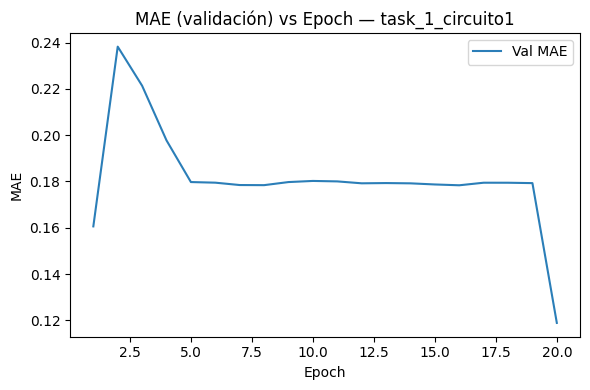

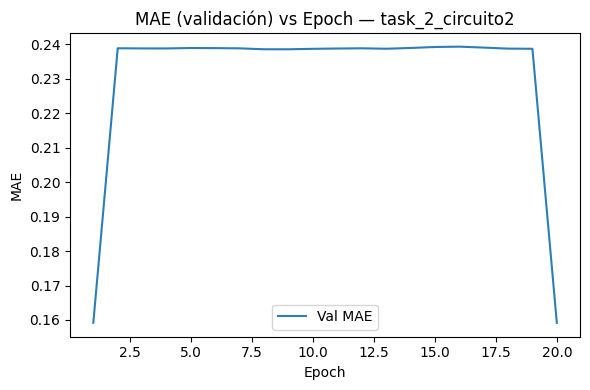

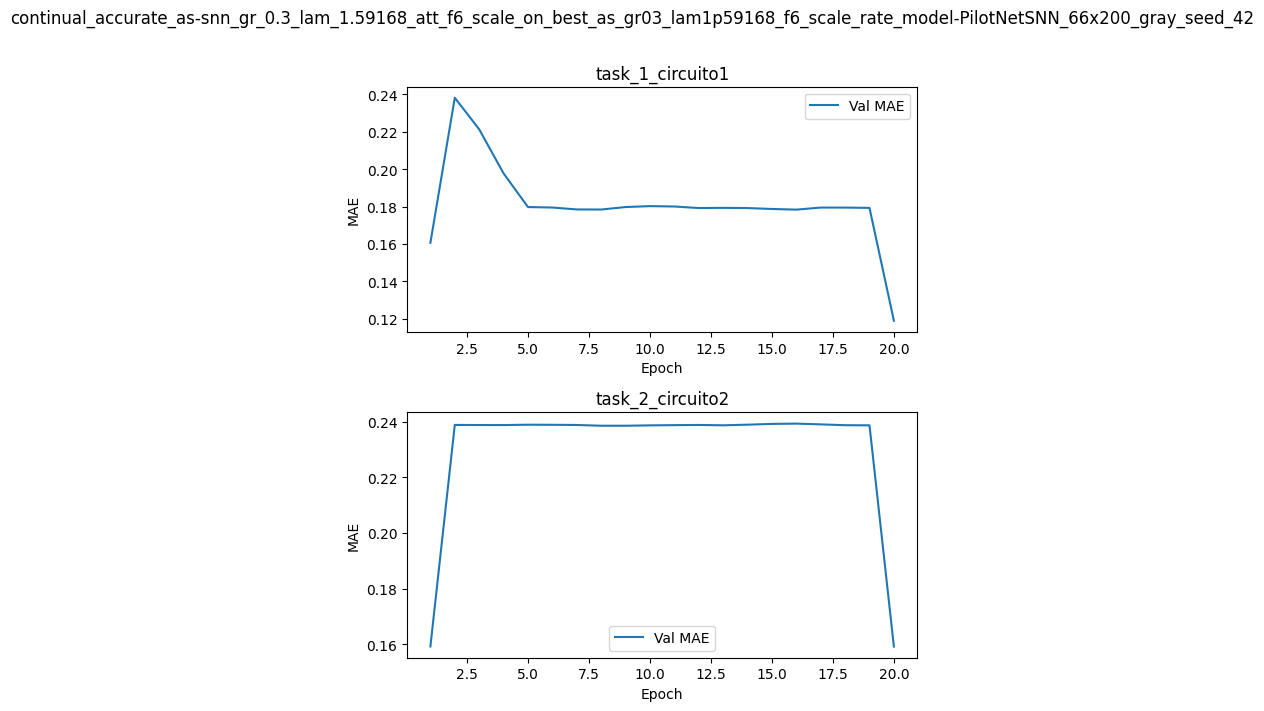

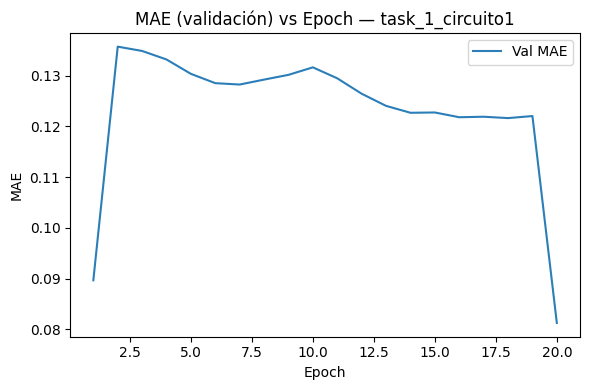

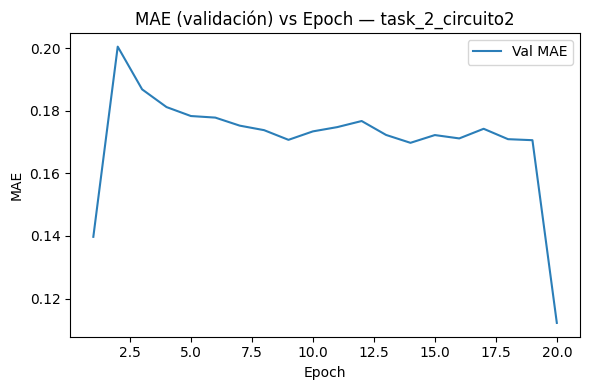

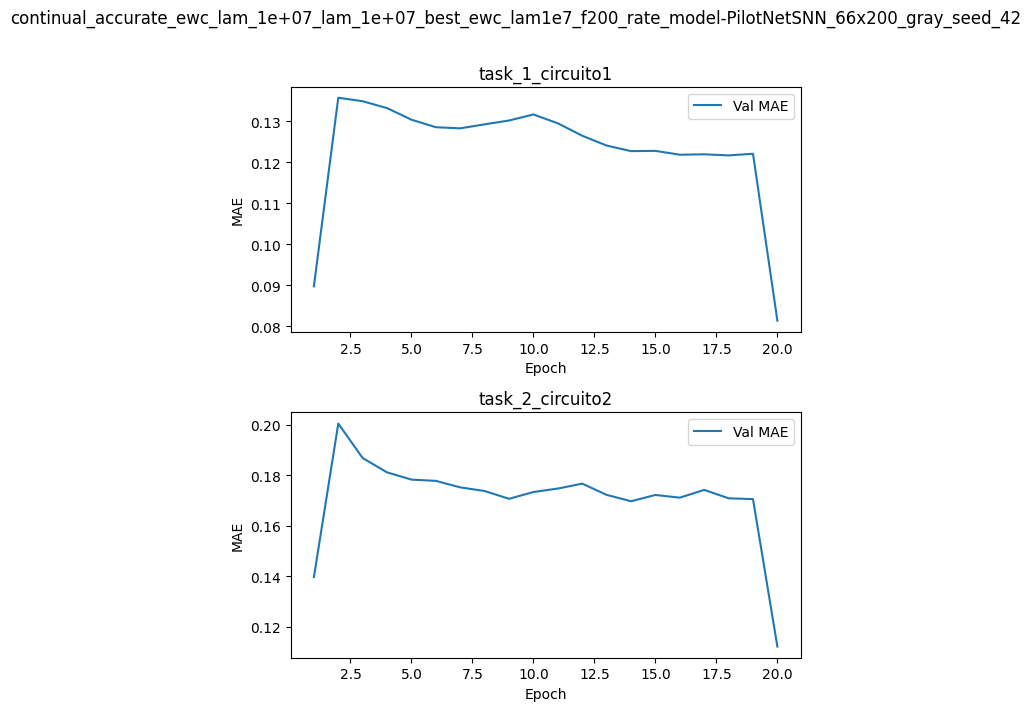

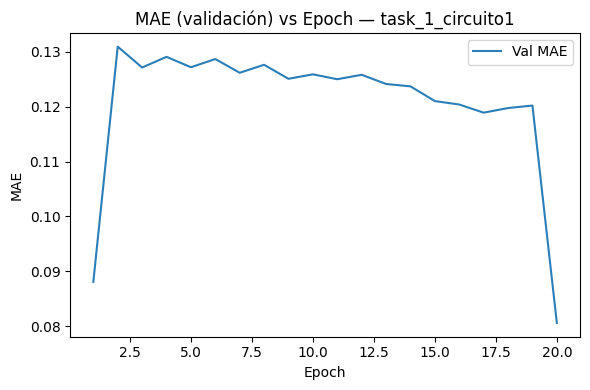

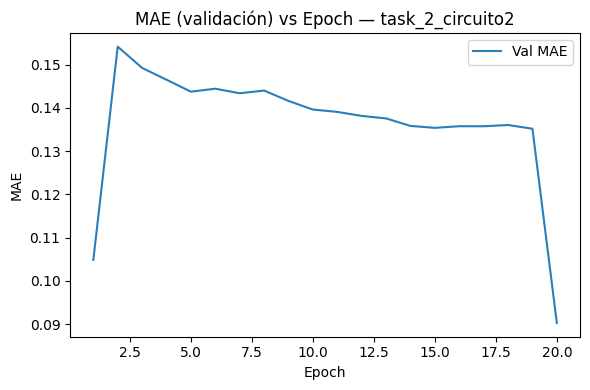

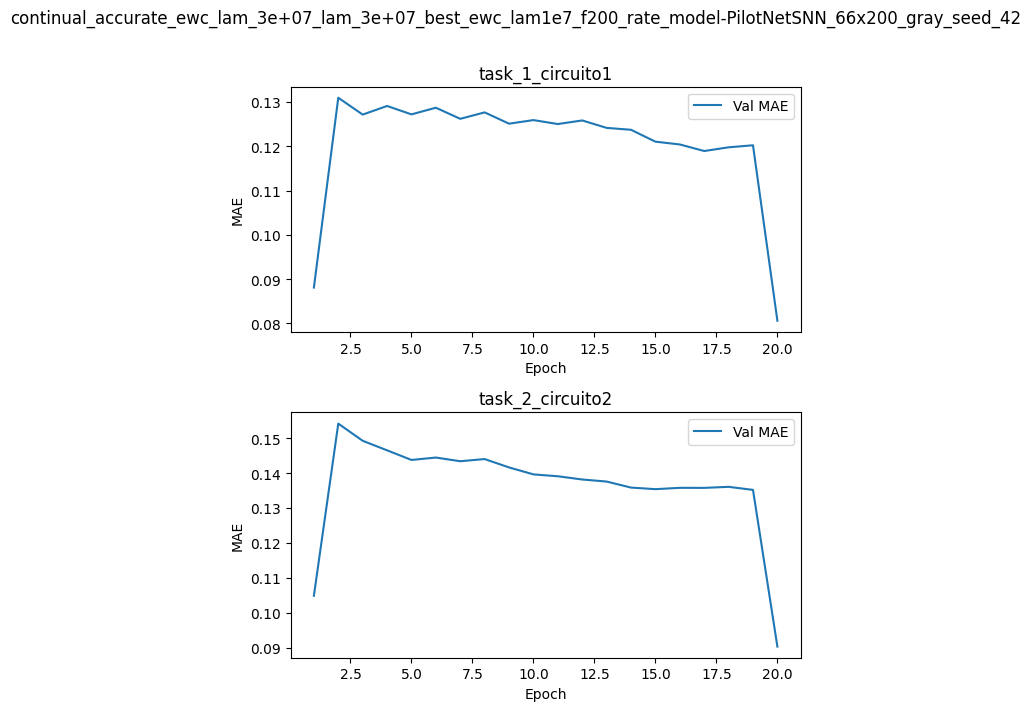

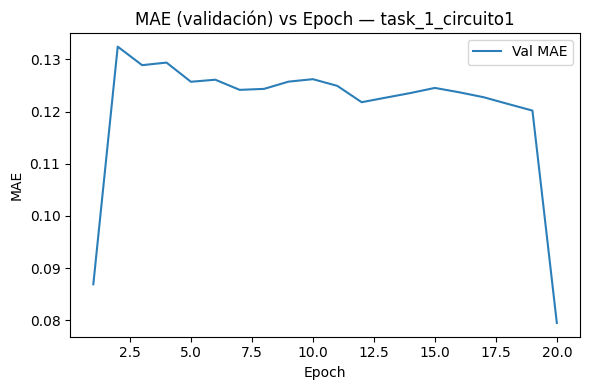

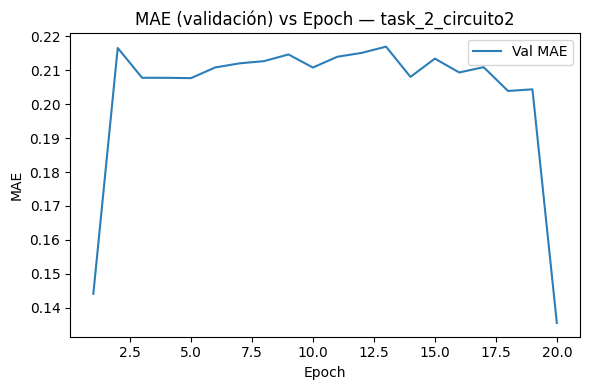

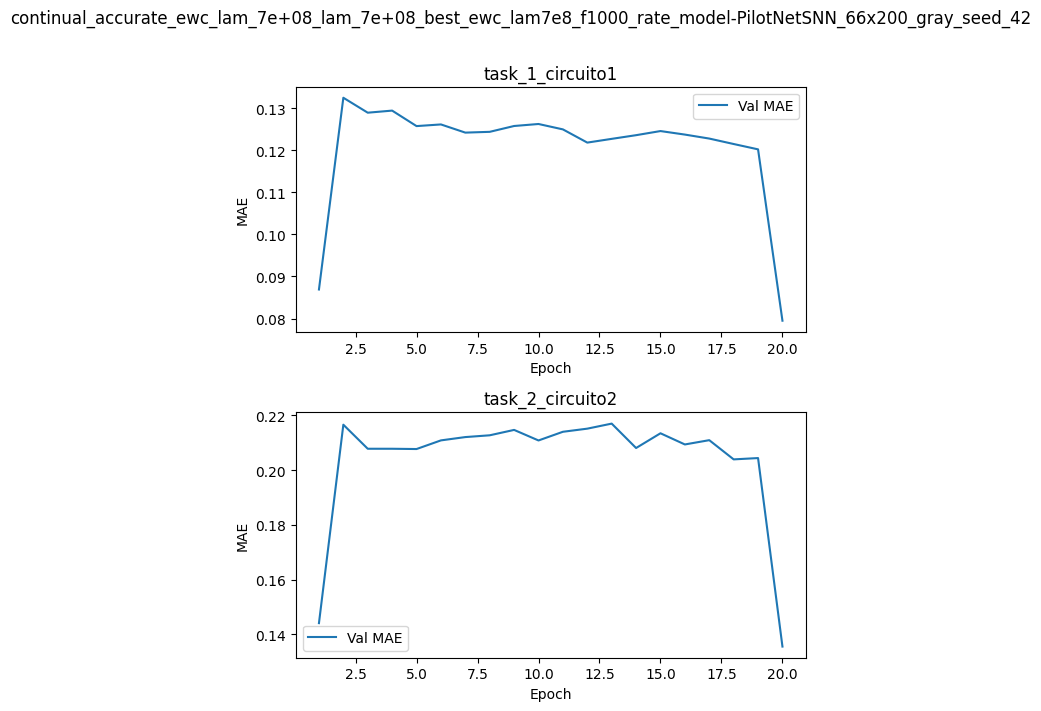

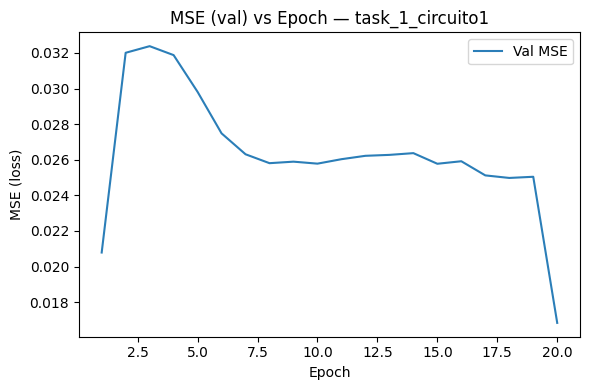

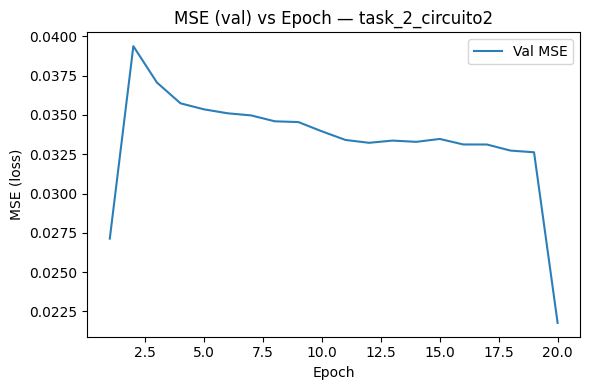

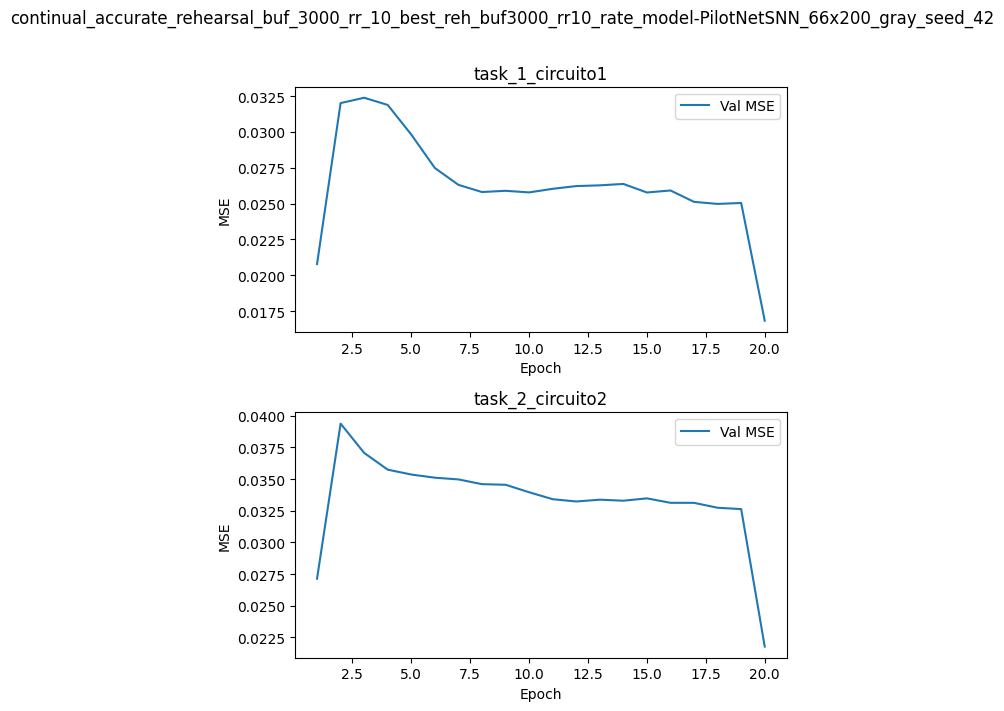

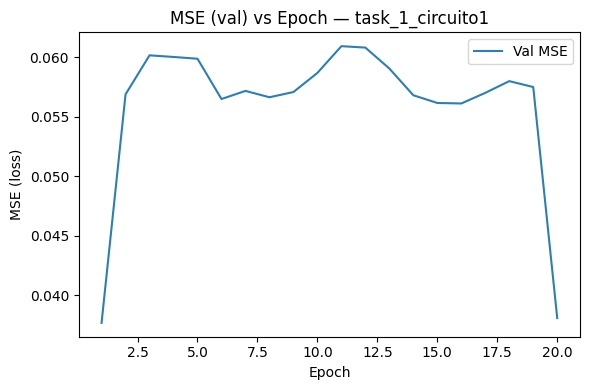

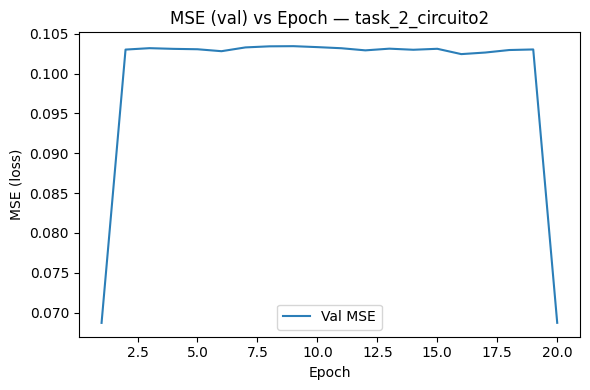

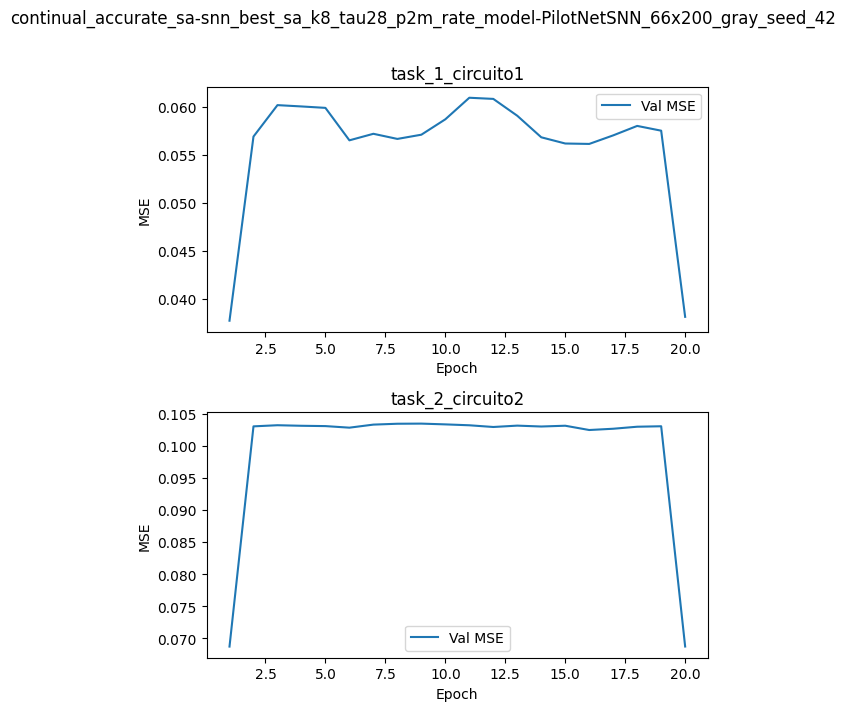

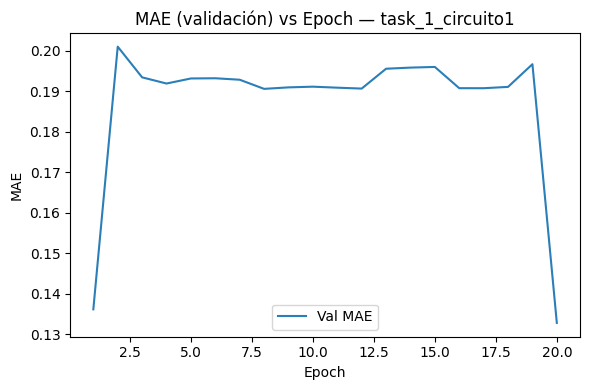

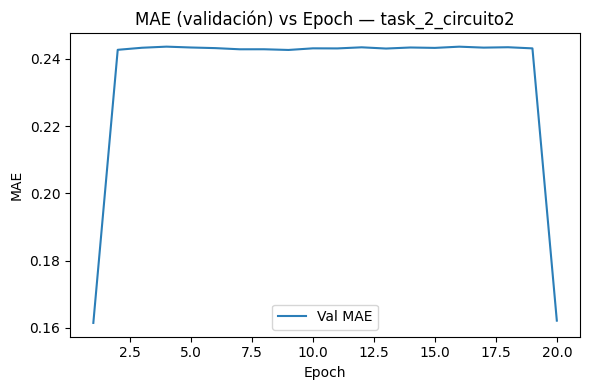

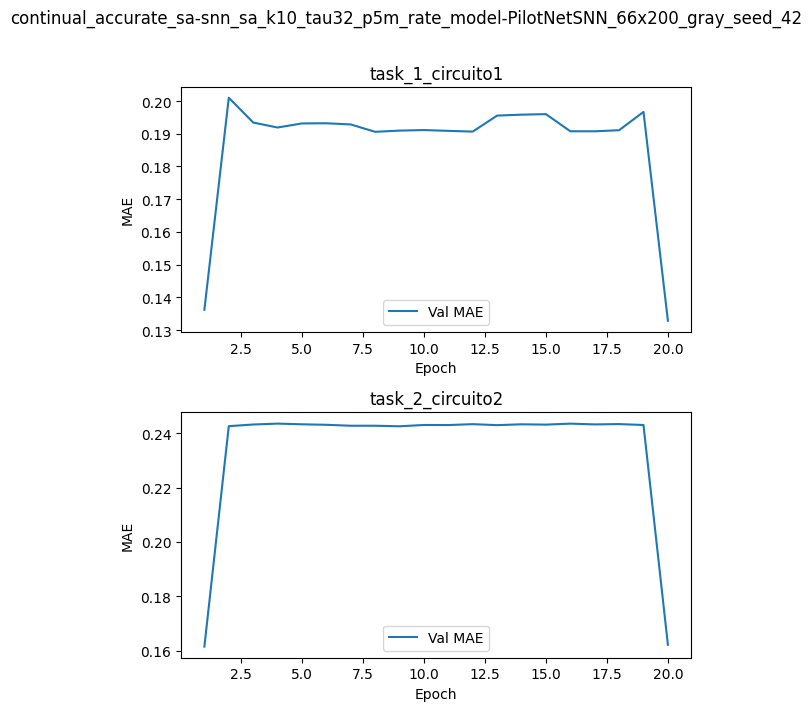

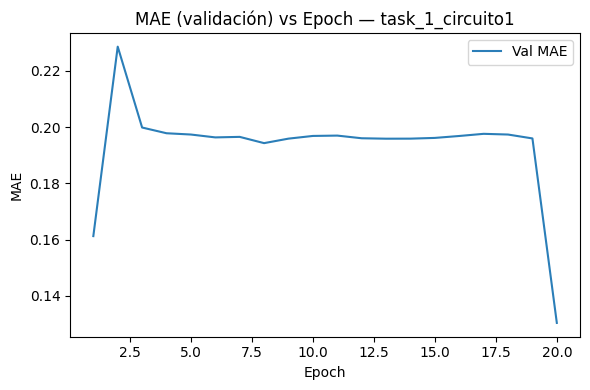

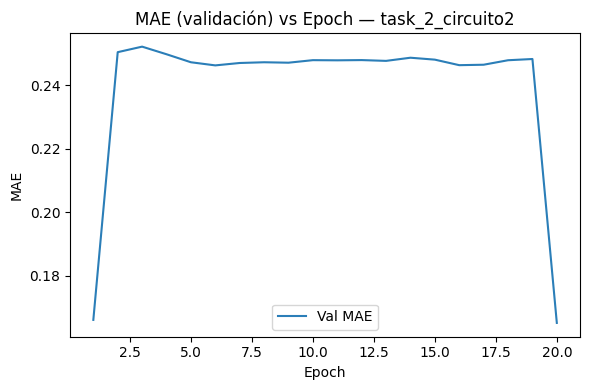

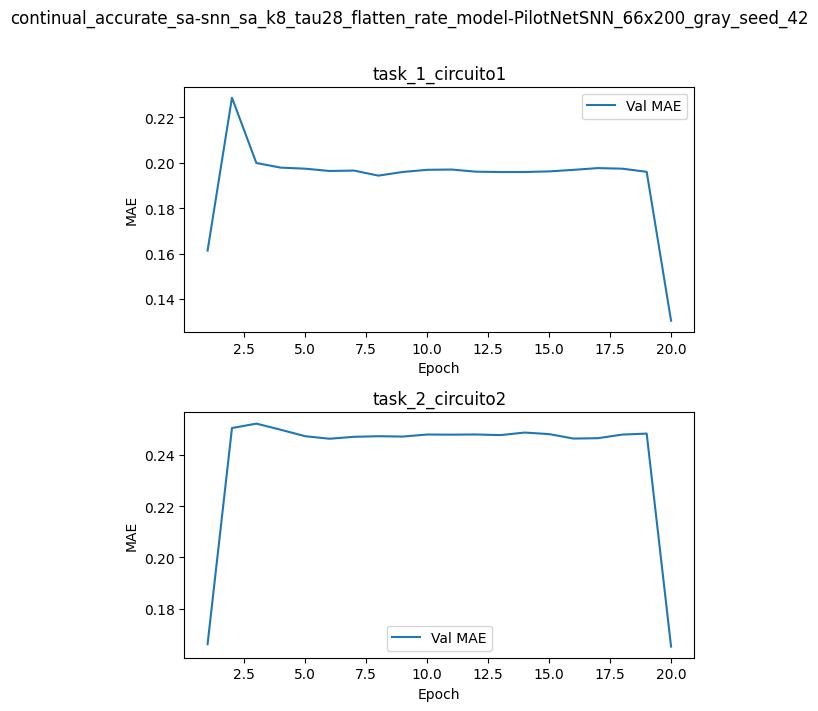

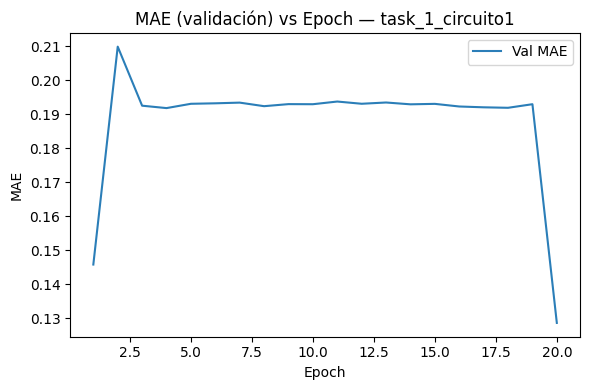

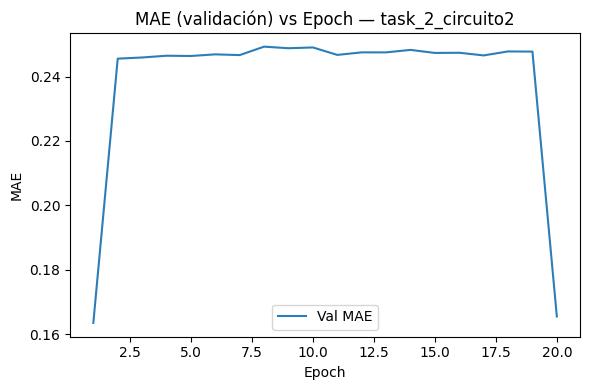

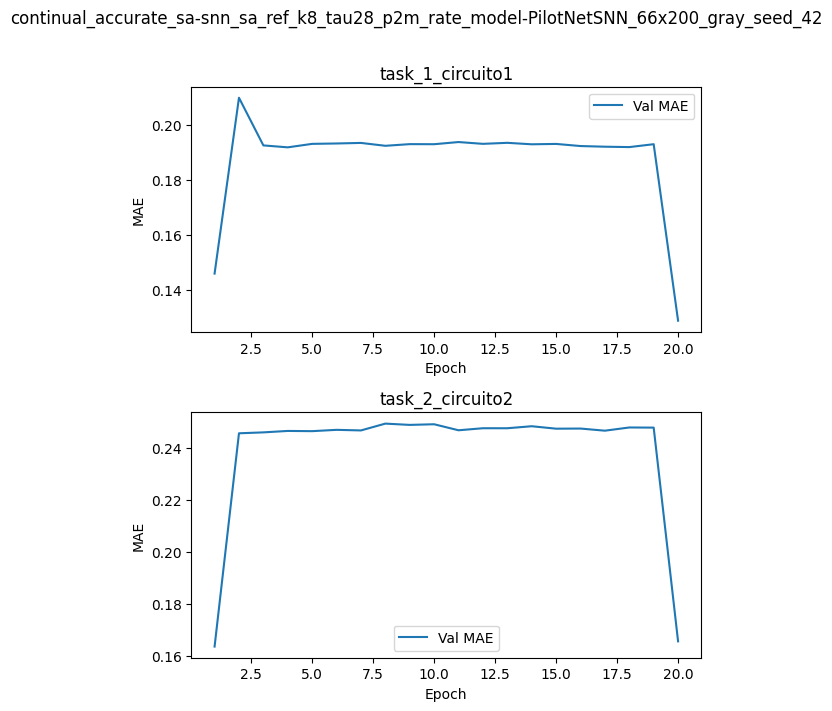

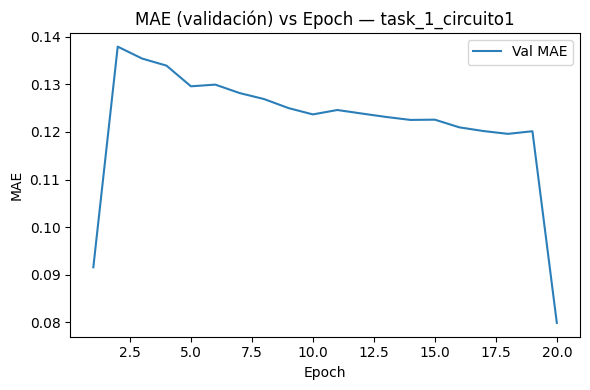

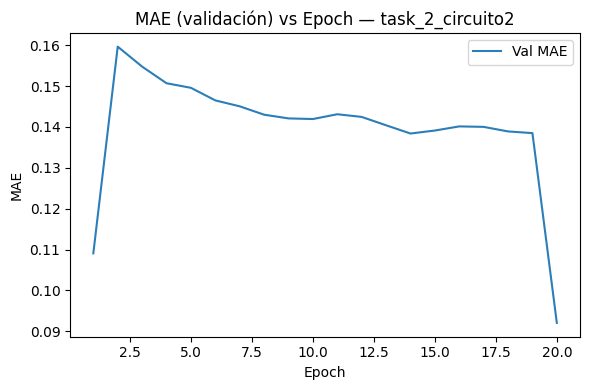

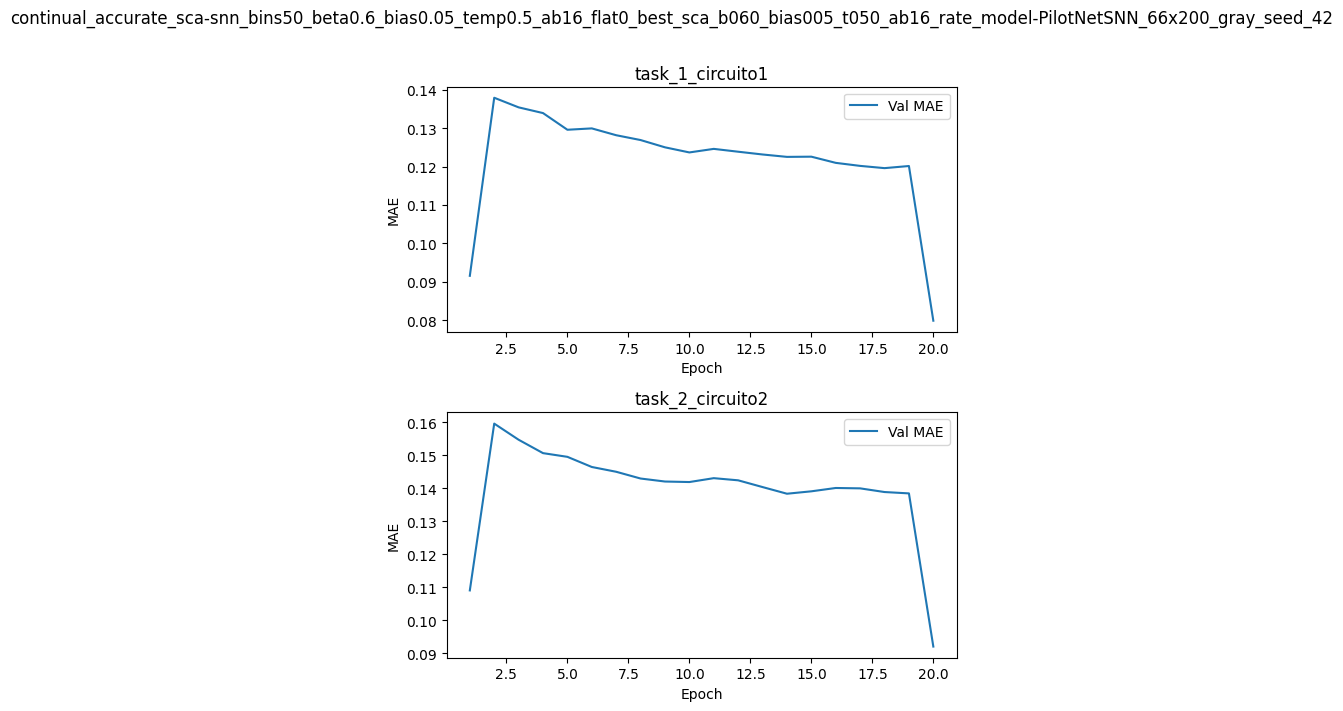

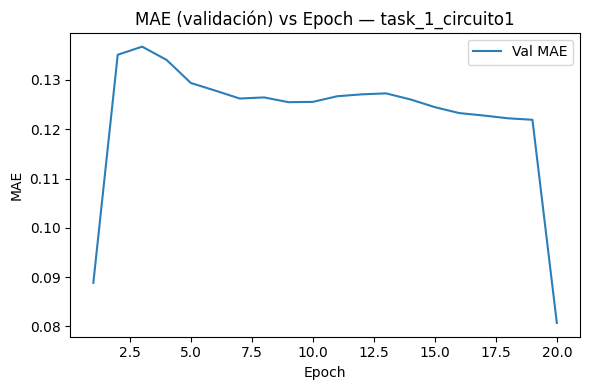

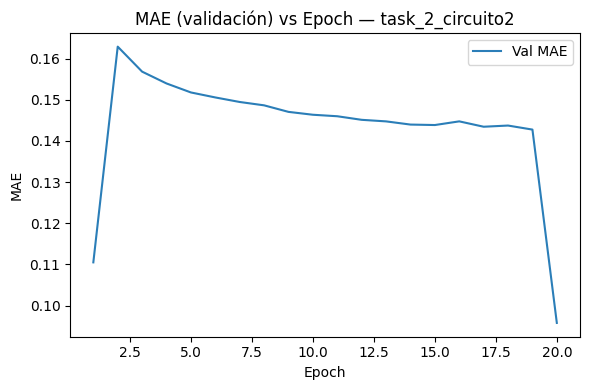

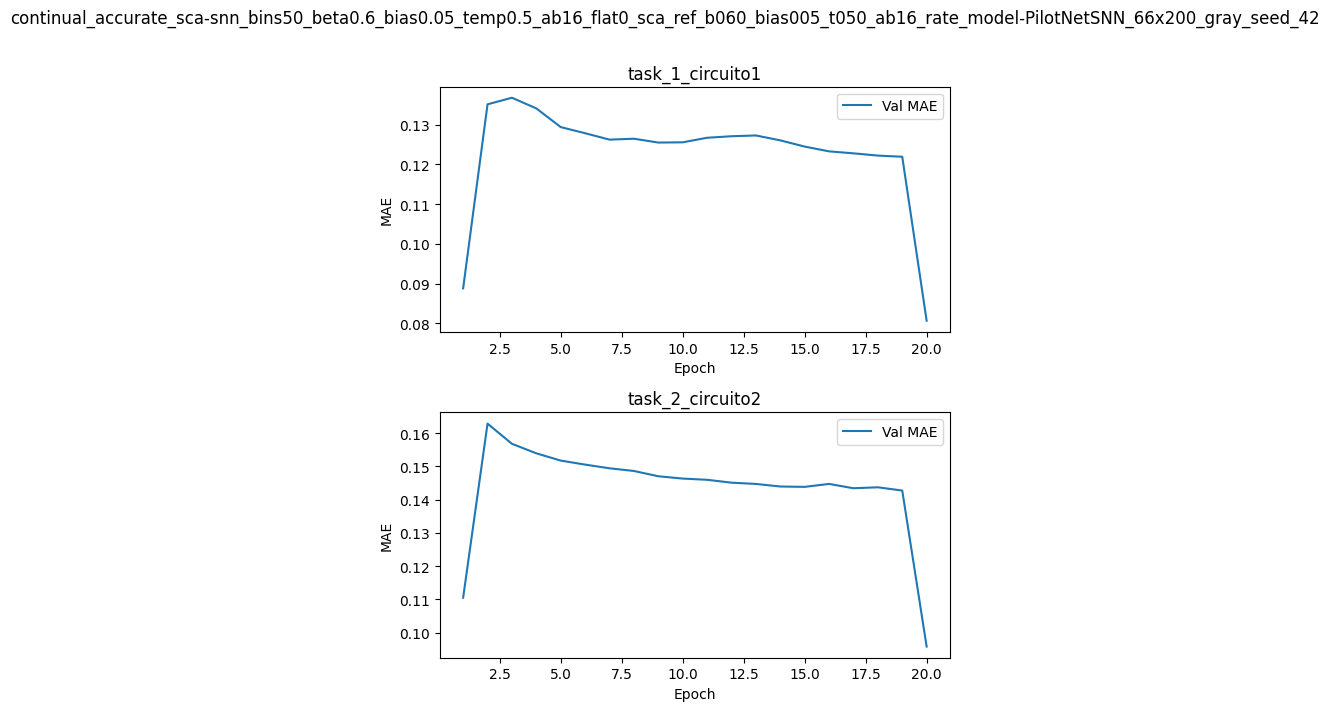

[OK] Curvas por run → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/plots_val_metrics


/home/cesar/proyectos/TFM_SNN/src/plots.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


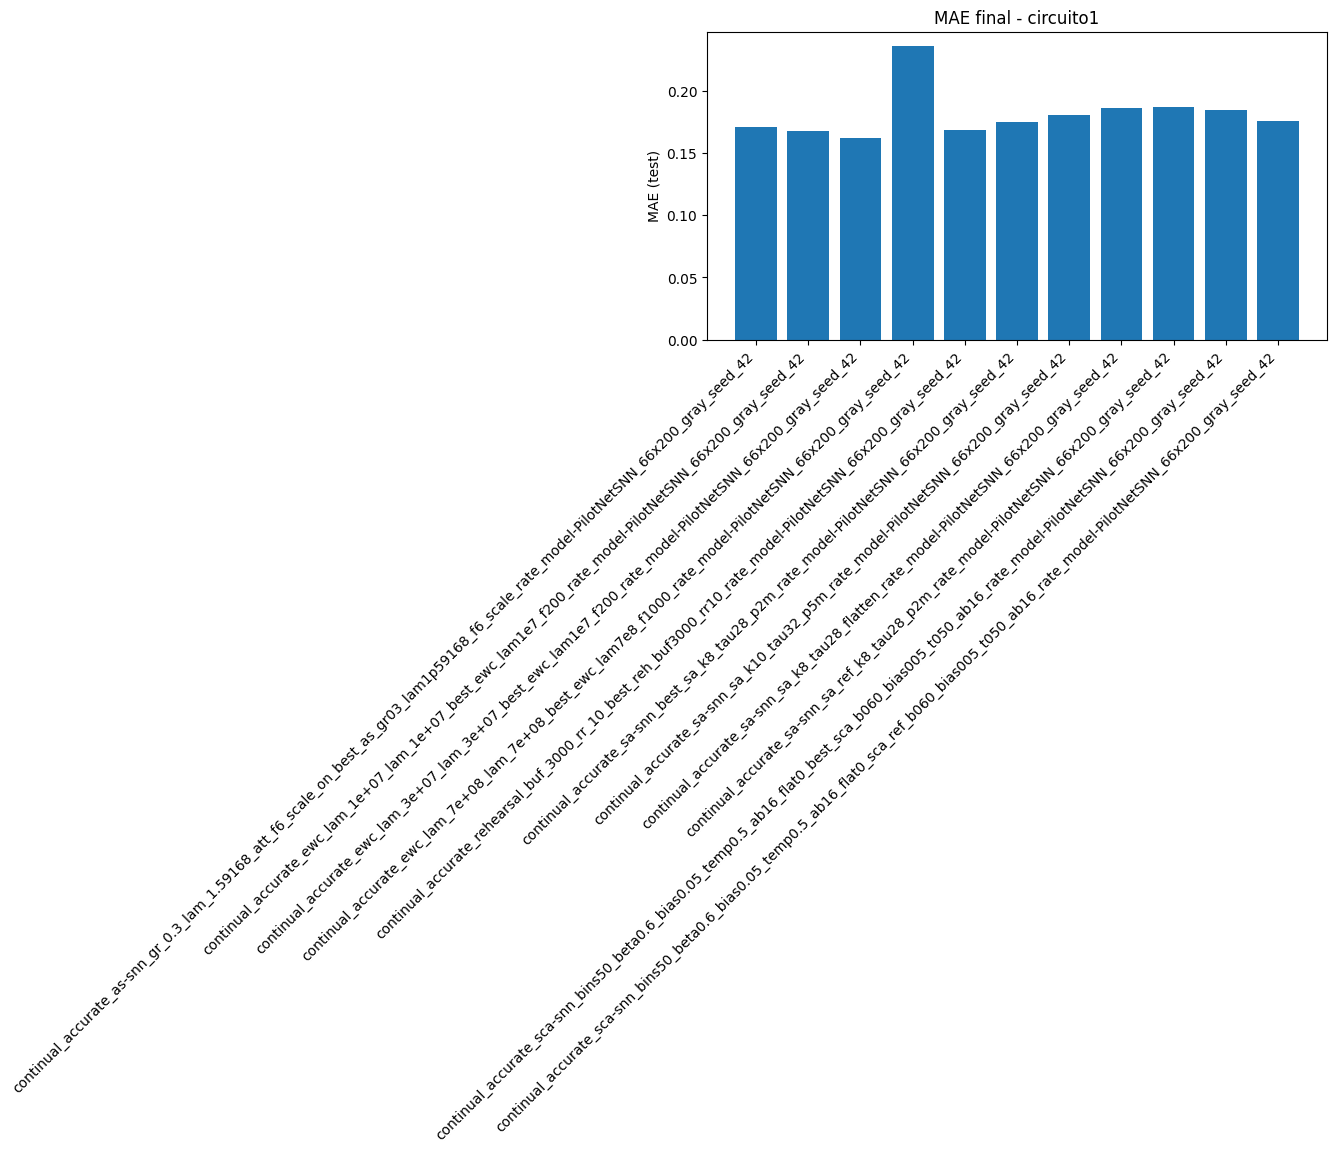

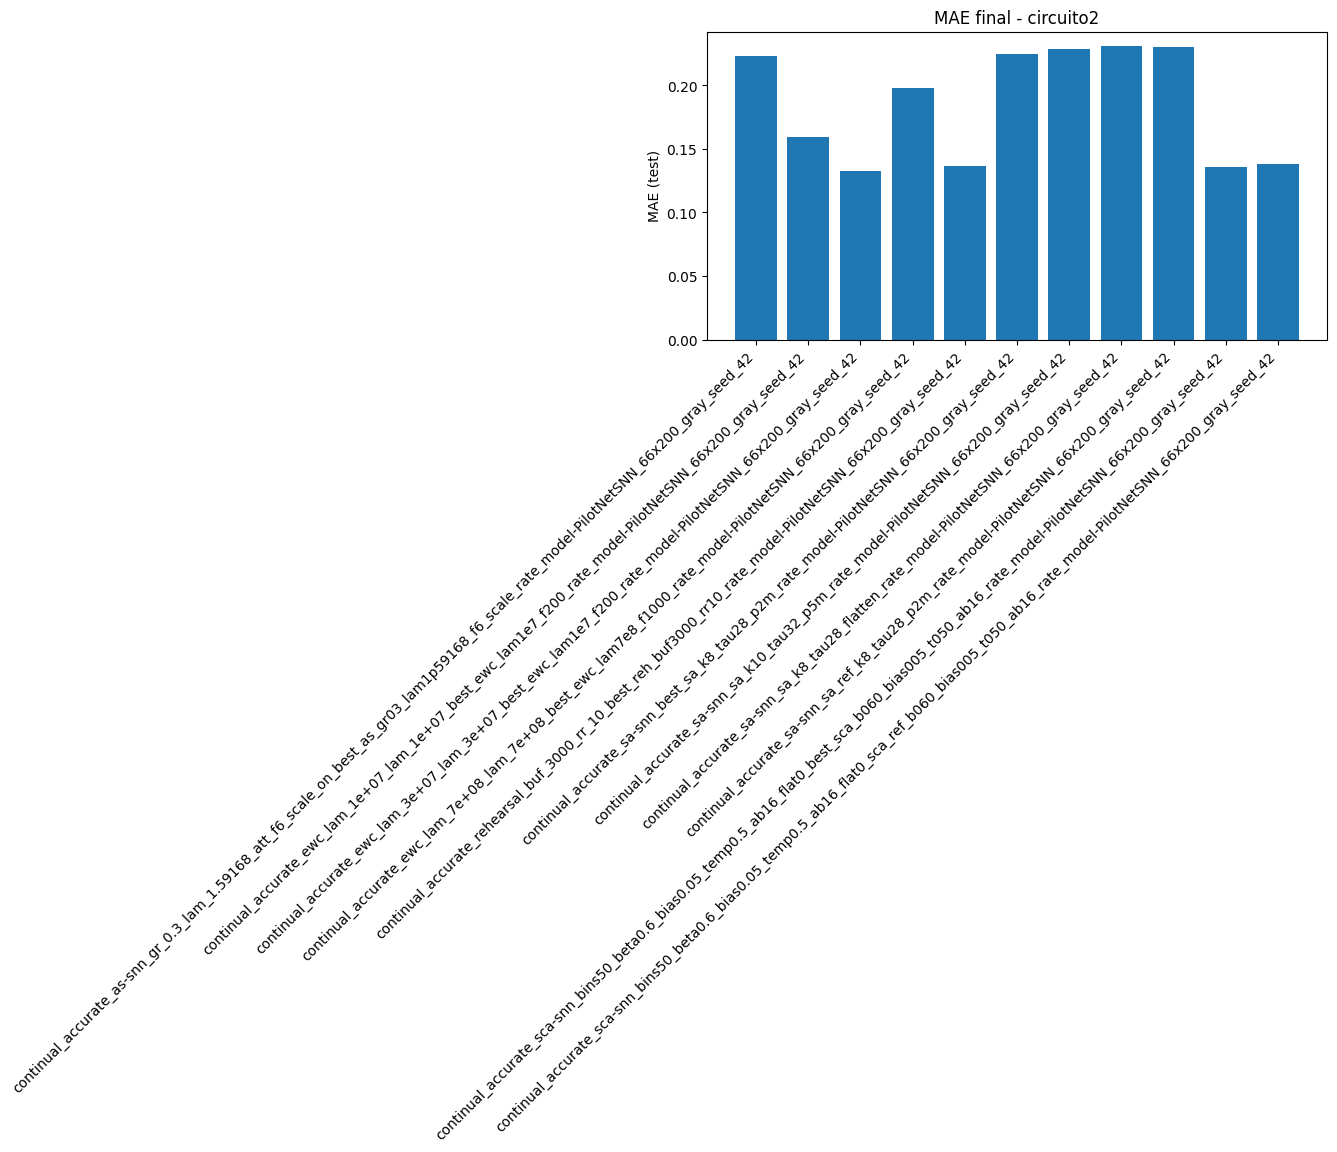

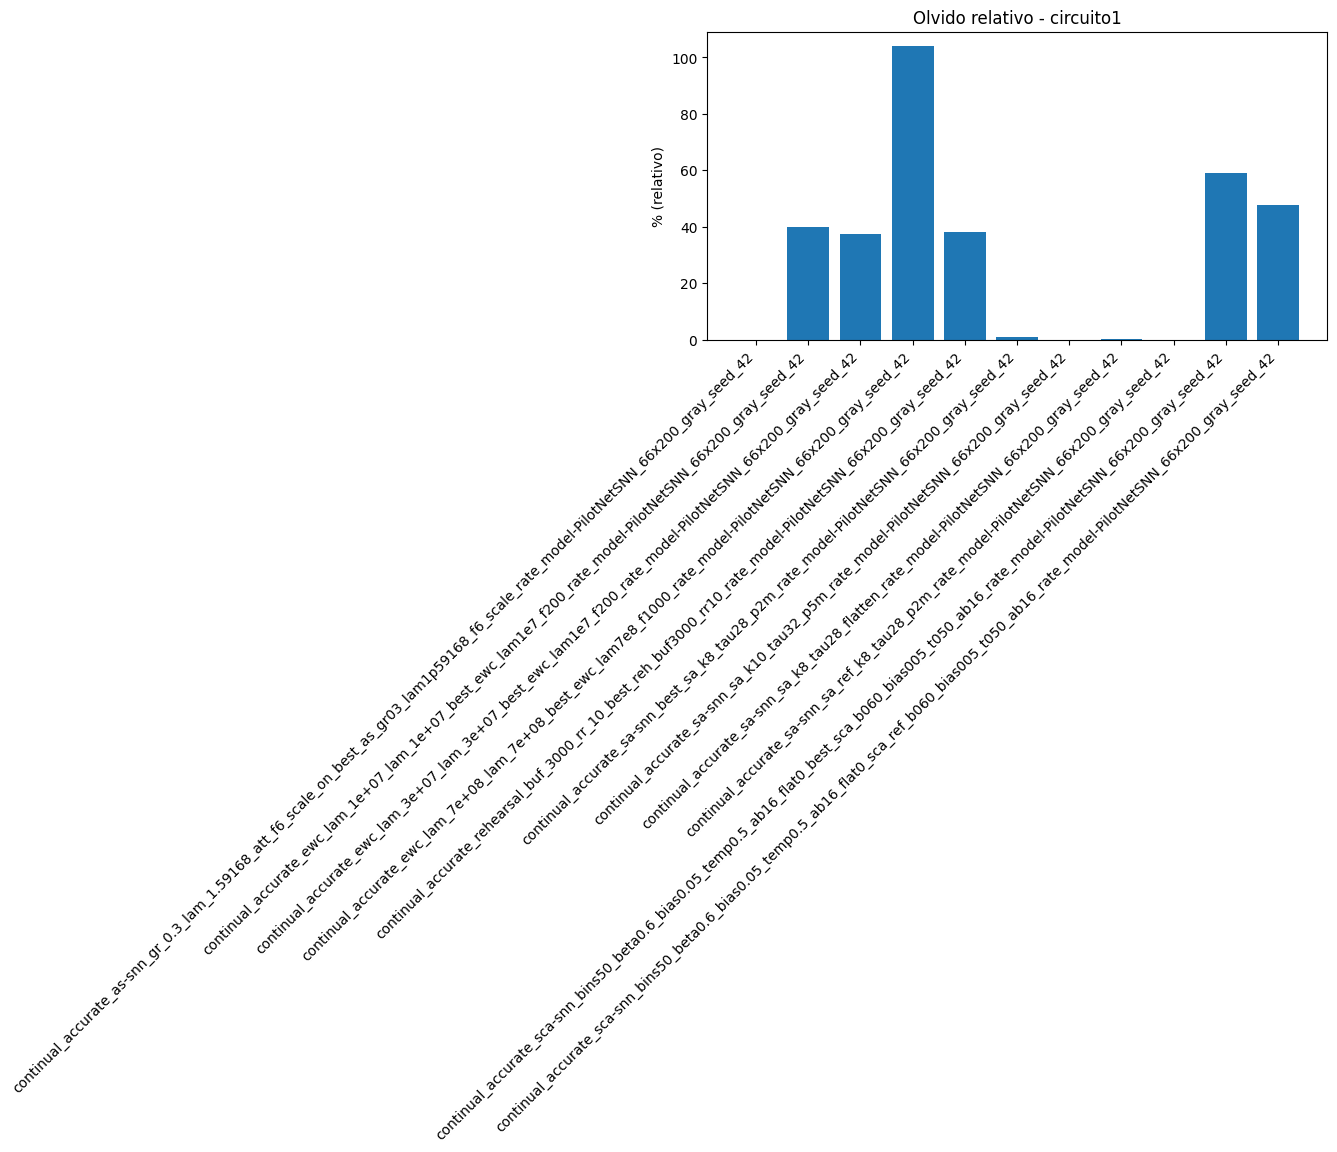

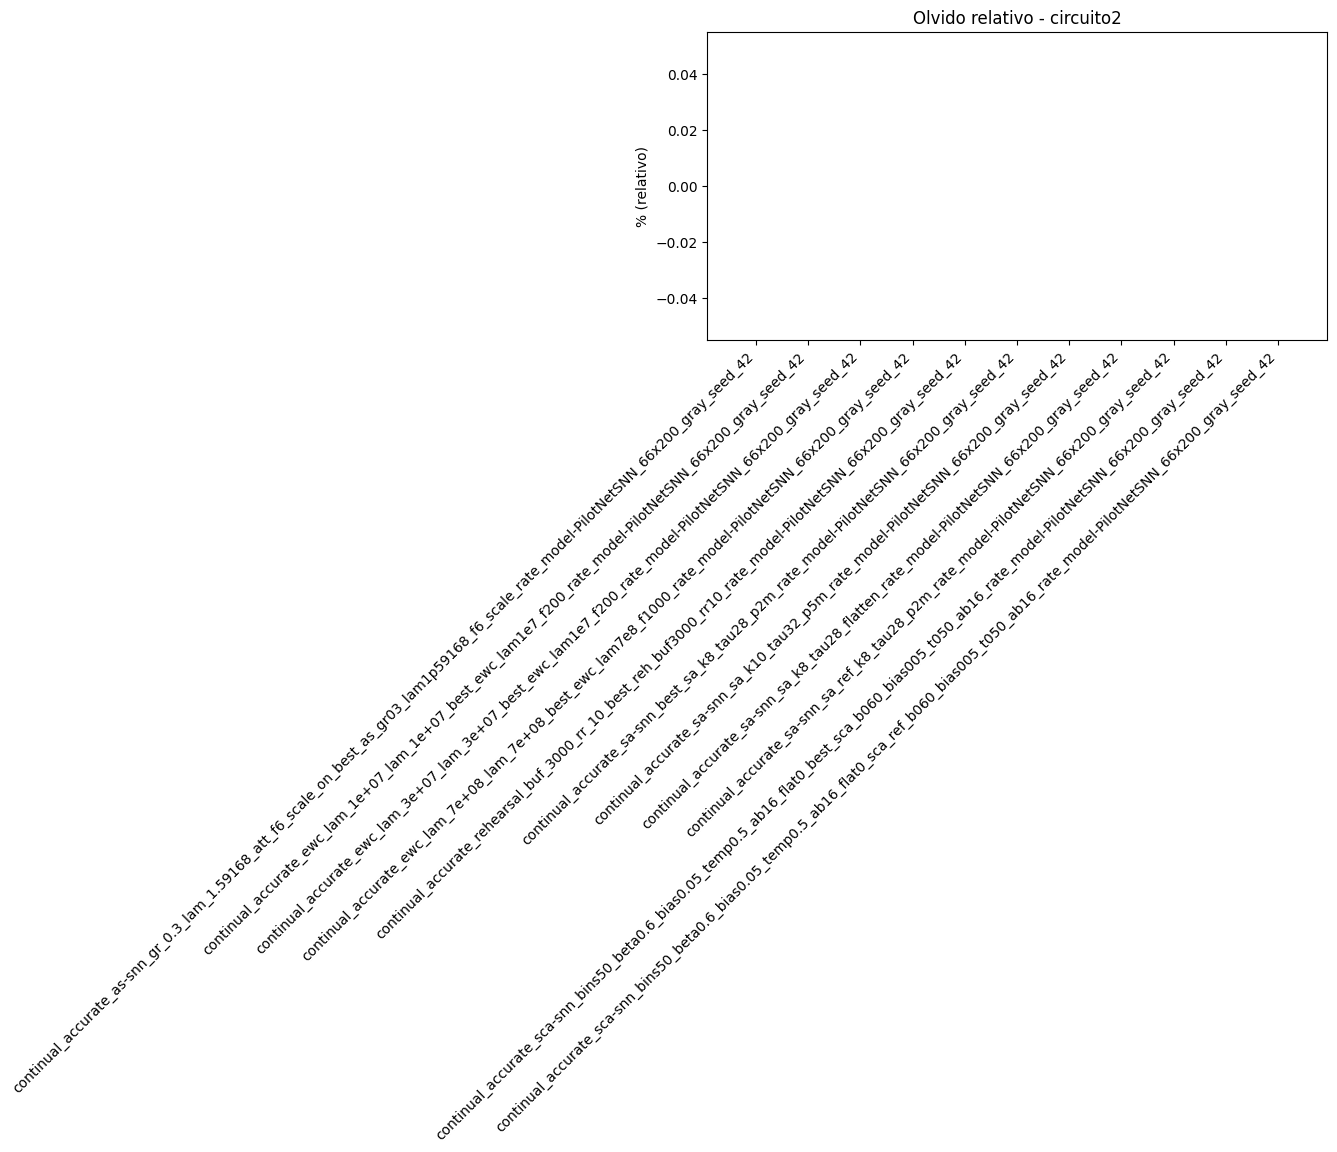

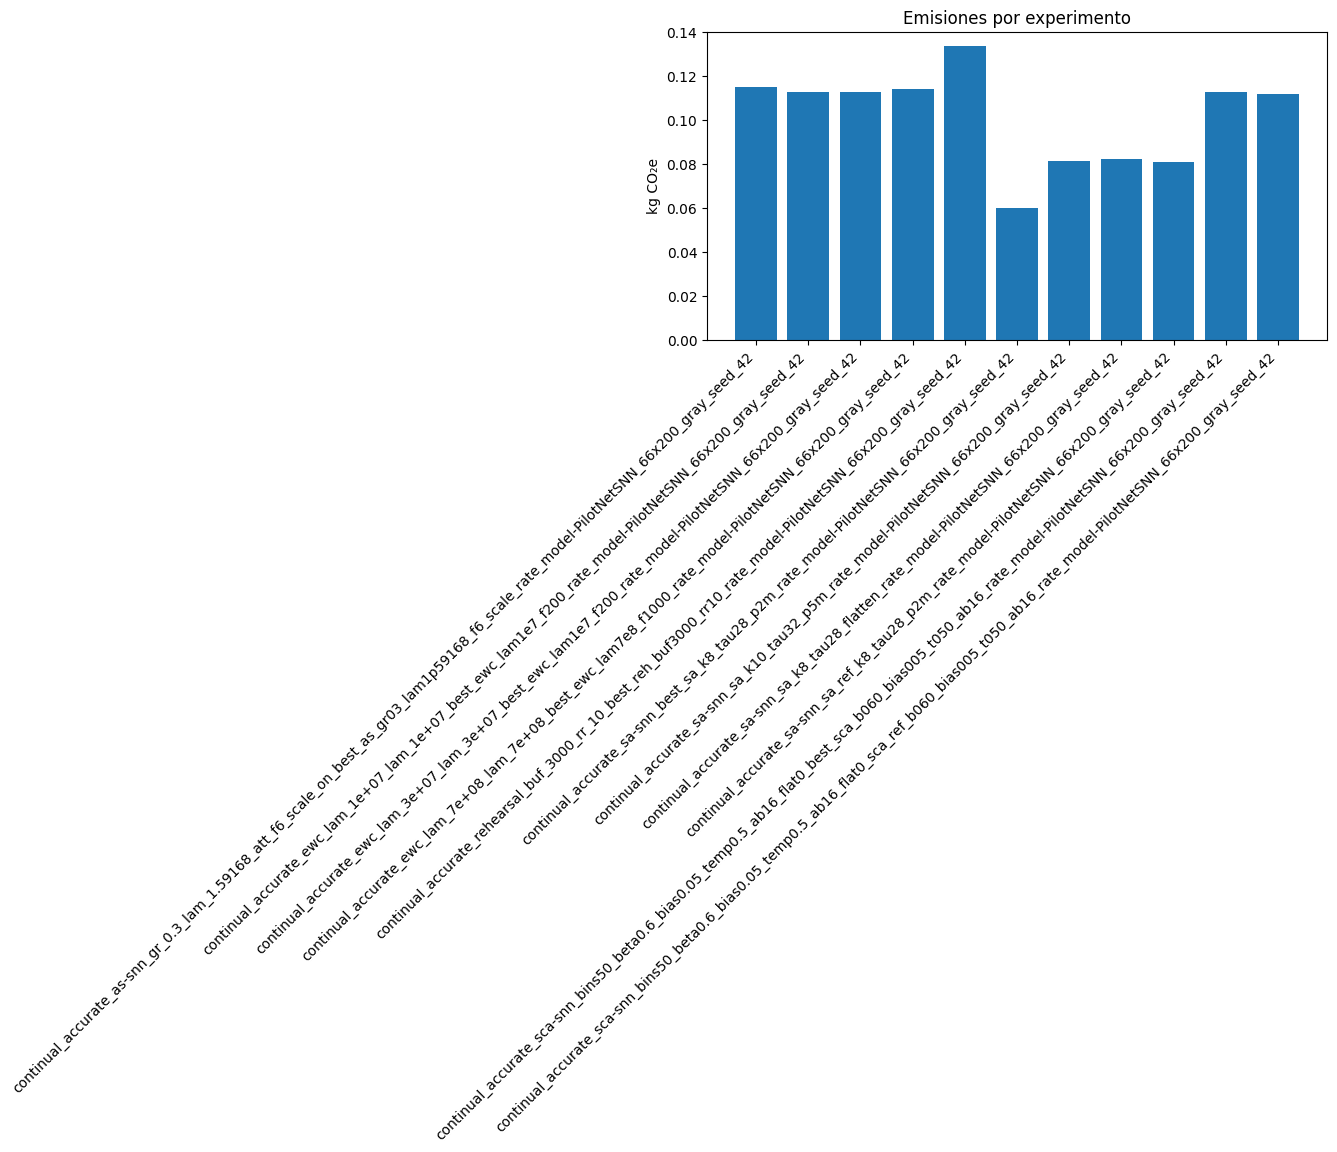

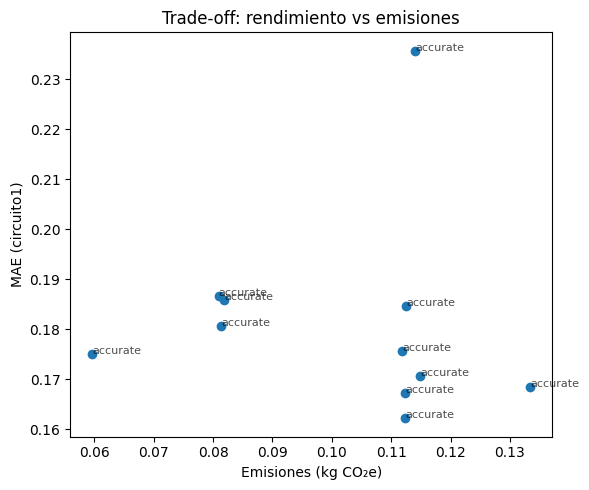

[OK] plot_across_runs → /home/cesar/proyectos/TFM_SNN/outputs/summary/paper_set_accurate_2025-11-03/plots_across_runs


In [7]:
# Celda 6 — Curvas epoch y barras comparativas sólo para df_sel (no barrer OUT entero)

from src.plots import plot_across_runs, plot_mae_curves_for_run as plot_loss_curves_for_run

# Curvas por run (val_loss/val_mae), restringido a la selección
if plot_loss_curves_for_run is not None:
    base_plots = THIS_SUMMARY / "plots_val_metrics"
    base_plots.mkdir(parents=True, exist_ok=True)
    for rd in sorted(set(df_sel["run_dir"].astype(str))):
        try:
            plot_loss_curves_for_run(_abs_run_dir(rd), base_plots, smooth_window=3)
        except Exception as e:
            print(f"[WARN] Falló curvas en {Path(rd).name}: {e}")
    print("[OK] Curvas por run →", base_plots)
else:
    print("[INFO] plot_mae_curves_for_run no disponible; saltando.")

# Barras y trade-offs “across runs”, restringido a la selección
if plot_across_runs is not None:
    dest_acc = THIS_SUMMARY / "plots_across_runs"
    dest_acc.mkdir(parents=True, exist_ok=True)
    try:
        plot_across_runs(df_sel, dest_acc)
        print("[OK] plot_across_runs →", dest_acc)
    except Exception as e:
        print("[WARN] plot_across_runs falló:", e)
else:
    print("[INFO] plot_across_runs no disponible; saltando.")

Celda 7 — Auditoría rápida (por qué se excluye algo)

In [8]:
# Celda 7 — Auditoría de exclusiones (opcional)

def audit_exclusions(df_all, df_sel):
    used = set(df_sel["run_dir"])
    cand = df_all.copy()
    cand["in_selection"] = cand["run_dir"].isin(used)
    excl = cand[~cand["in_selection"]].copy()
    if excl.empty:
        print("[AUDIT] No hay excluidos.")
        return
    cols = ["run_dir","preset","method_base","encoder","model","seed","T","amp","mtime_dt"]
    for c in cols:
        if c not in excl.columns:
            excl[c] = np.nan
    # Motivos típicos
    excl["fail_preset"] = PRESET_FILTER and (excl["preset"] != PRESET_FILTER)
    excl["fail_enc"]    = ENCODER_FILTER and (excl["encoder"] != ENCODER_FILTER)
    excl["fail_seed"]   = (SEED_FILTER is not None) & (excl["seed"] != SEED_FILTER)
    excl["fail_method"] = METHODS_KEEP and (~excl["method_base"].isin(METHODS_KEEP))
    excl["fail_newrun"] = ONLY_NEW_RUNNER and (excl.get("is_new_runner", False) != True)
    excl["fail_date"]   = (MTIME_FROM is not None) & (excl["mtime"] < MTIME_FROM.timestamp())
    excl["fail_tag"]    = bool(TAG_INCLUDE_SUBSTR) and ~excl["run_dir"].astype(str).apply(lambda s: any(t in s for t in TAG_INCLUDE_SUBSTR))
    excl["fail_whitelist"] = bool(RUN_DIR_WHITELIST) and ~excl["run_dir"].isin(RUN_DIR_WHITELIST)

    if STRICT_CFG:
        model_ok = excl["model"].astype(str).str.contains(MODEL_MATCH_SUBSTR, na=False)
        T_ok     = (pd.to_numeric(excl["T"], errors="coerce") == T_TARGET)
        amp_ok   = excl["amp"].astype(str).str.lower().isin(["true","1","yes"]) if AMP_REQUIRED else True
        excl["fail_model"] = ~model_ok
        excl["fail_T"]     = ~T_ok
        excl["fail_amp"]   = ~(amp_ok if isinstance(amp_ok, pd.Series) else True)
    display(excl[cols + [c for c in excl.columns if c.startswith("fail_")]].head(20))

audit_exclusions(df_all, df_sel)

,run_dir,preset,method_base,encoder,model,seed,T,amp,mtime_dt,fail_preset,fail_enc,fail_seed,fail_method,fail_newrun,fail_date,fail_tag,fail_whitelist,fail_model,fail_T,fail_amp
0,continual_accurate_as-snn_gr_0.3_lam_1.59168_r...,accurate,as-snn,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-18 13:32:20.574938297,False,False,False,False,True,True,False,False,False,False,False
2,continual_accurate_as-snn_gr_0.3_lam_1.6_grid0...,accurate,as-snn,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-29 10:29:16.076847553,False,False,False,False,False,True,False,False,False,False,False
6,continual_accurate_ewc_lam_7e+08_lam_7e+08_gri...,accurate,ewc,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-30 15:01:10.438538313,False,False,False,False,False,True,False,False,False,False,False
7,continual_accurate_ewc_lam_7e+08_lam_7e+08_rat...,accurate,ewc,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-17 05:26:27.334119797,False,False,False,False,True,True,False,False,False,False,False
8,continual_accurate_naive_grid01_rate_model-Pil...,accurate,naive,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-27 04:12:01.086065292,False,False,False,False,False,True,False,False,False,False,False
9,continual_accurate_naive_rate_model-PilotNetSN...,accurate,naive,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-16 23:54:16.736942291,False,False,False,False,True,True,False,False,False,False,False
11,continual_accurate_rehearsal_buf_3000_rr_10_ra...,accurate,rehearsal,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-17 10:51:35.387532711,False,False,False,False,True,True,False,False,False,False,False
12,continual_accurate_rehearsal_buf_3000_rr_20_ra...,accurate,rehearsal,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-21 01:39:51.570433617,False,False,False,False,True,True,False,False,False,False,False
13,continual_accurate_rehearsal_buf_3000_rr_20+ew...,accurate,rehearsal+ewc,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-17 19:03:05.072840691,False,False,False,True,True,True,False,False,False,False,False
18,continual_accurate_sa-snn_k6_tau42_th1-2_p7000...,accurate,sa-snn,rate,PilotNetSNN_66x200_gray,42,30.0,True,2025-10-20 15:47:17.344774246,False,False,False,False,True,True,False,False,False,False,False
